<a href="https://colab.research.google.com/github/egorneo/Course-work/blob/main/PointCloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notes


In [ ]:
# Num points ~ accuracy(prob); different params +
# +Change intervals of parameters
# distriution

# Torus equation - ? + Magnitude of a,b,c and MSE
# Existance of eq



# TDA
# Good triangulation
# 2 ord points.=> equation

# Probability
#
# Noise (TRY) - done
#
# Genus >=2
#
# Skewed
# Non-symmetric

#18.10
#English presentation
#Test on noisy data/Train on noisy data(different ones) [different distributions]
#latex

#formulation
#Fixed surface
#Noise
#Random numbers
#Check if parameter distribution is fair
#Check cited by
#Talk on seminar
#

#10-15 ref
#



In [ ]:
#
#
#
#

In [ ]:
# y^2 = P(x), y=a+ib, x = c+i*d
# x in a cell

In [ ]:
# Hyperelliptic curve draw genus g?

## Experiments tracking setup


In [1]:
!pip install wandb -qU

In [2]:
# Log in to your W&B account
import wandb
import random
import math

In [3]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: egor-novgorodov to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Imports


In [4]:
import numpy as np
import math
import random
import os
import torch
import shutil
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px


random.seed = 42

## Generation

In [5]:
def generate_sphere_coords(N, a=1, b=4):
    u = np.random.uniform(0, 2*np.pi, N) #Not random?
    v = np.random.uniform(0, np.pi, N)

    (a,b,c) = (np.random.uniform(a,b),np.random.uniform(a,b),1)

    x = a*np.cos(u)*np.sin(v)
    y = b*np.sin(u)*np.sin(v)
    z = c*np.cos(v)

    x = np.reshape(x, (1,-1))
    y = np.reshape(y, (1,-1))
    z = np.reshape(z, (1,-1))
    coords = np.concatenate([x,y,z],axis=0).T
    return coords

def generate_torus_coords(N, a=1, b=4):
    u = np.random.uniform(0,2*np.pi,N)
    v = np.random.uniform(0,2*np.pi,N)

    c, a = (np.random.uniform(a,b), 1)

    x = (c + a * np.cos(v)) * np.cos(u)
    y = (c + a * np.cos(v)) * np.sin(u)
    z = a * np.sin(v)

    x = np.reshape(x, (1,-1))
    y = np.reshape(y, (1,-1))
    z = np.reshape(z, (1,-1))
    coords = np.concatenate([x,y,z],axis=0).T
    return coords

def gen_callback_ab(gen_func, a, b):
  return (lambda N: gen_func(N, a, b))

def generate_save(N=300, n=100, gen_func=generate_sphere_coords, class_name='spheres', force_generation=True, split='train'):
    '''
      N = 300 number of points in a cloud
      n = 100 number of instances
    '''
    dir = './dataset'

    if not os.path.isdir(dir):
        os.mkdir(dir)

    dir = os.path.join(dir, split)
    if not os.path.isdir(dir):
        os.mkdir(dir)
    if force_generation and os.path.isdir(os.path.join(dir,class_name)):
        shutil.rmtree(os.path.join(dir, class_name))

    working_dir = os.path.join(dir, class_name)
    if os.path.isdir(working_dir):
        print('{class_name} already generated')
    else:
        os.mkdir(working_dir)
        for i in range(n):
            coords = gen_func(N)
            np.savetxt(os.path.join(working_dir ,f'{i}'), coords)

def generate_save_all():
    generate_save(N=300, n=100, gen_func=generate_sphere_coords, class_name='spheres', force_generation=True, split='train')
    generate_save(N=300, n=100, gen_func=generate_sphere_coords, class_name='spheres', force_generation=True, split='test')
    generate_save(N=300, n=100, gen_func=generate_torus_coords, class_name='tori', force_generation=True, split='train')
    generate_save(N=300, n=100, gen_func=generate_torus_coords, class_name='tori', force_generation=True, split='test')


In [6]:
generate_save_all()

## Transforms

### Normalize

In [7]:
def normalize_tensorify(pointcloud, noise = 0):
  assert len(pointcloud.shape)==2
  norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0)
  norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))
  norm_pointcloud += np.random.normal(0, noise, np.shape(norm_pointcloud))

  return  torch.tensor(norm_pointcloud)


### Unit sphere visualization

In [8]:
def visualize(pointcloud):
  fig = px.scatter_3d(x= norm_pointcloud[:,0] ,y=norm_pointcloud[:,1],z=norm_pointcloud[:,2])
  fig.update_traces(marker=dict(size=3)) # Adjust the 'size' parameter as needed
  fig.show()

pointcloud = np.loadtxt('./dataset/test/spheres/56')
norm_pointcloud = normalize_tensorify(pointcloud, noise=0.05)

visualize(norm_pointcloud)

## Dataset

In [9]:
class PointCloudData(Dataset):
    def __init__(self, root_dir='./dataset', folder="train", transform=normalize_tensorify, noise=0.03):
        self.root_dir = root_dir
        split_dir = os.path.join(root_dir, folder)

        folders = [dir for dir in sorted(os.listdir(split_dir))]

        self.classes = {folder: i for i, folder in enumerate(folders)}
        #TODO Развязать зависимость от normalize_tensorify
        self.transforms = lambda x: transform(x, noise)

        self.files = []
        for category in self.classes.keys():
            cat_dir = os.path.join(split_dir, category)
            for file in os.listdir(cat_dir):
                sample = {}
                sample['pcd_path'] = os.path.join(cat_dir, file)
                sample['category'] = category
                self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        coords = np.loadtxt(file)
        if self.transforms:
            pointcloud = self.transforms(coords)
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud,
                'category': self.classes[category]}

In [10]:
train_ds = PointCloudData(folder='train')
valid_ds = PointCloudData(folder='test')

In [11]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'spheres', 1: 'tori'}

In [14]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  200
Valid dataset size:  200
Number of classes:  2
Sample pointcloud shape:  torch.Size([300, 3])
Class:  spheres


In [13]:
train_loader = DataLoader(dataset=train_ds, batch_size=64, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64, shuffle=True)

Automated dataset generation


In [15]:
def generate_loaders(N = 300, n = 100, FORCE_GENERATION = False):
    main(N,n , FORCE_GENERATION, 'train')
    main(N, n, FORCE_GENERATION, 'test')
    train_ds = PointCloudData(folder='train')
    valid_ds = PointCloudData(folder='test')
    train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
    valid_loader = DataLoader(dataset=valid_ds, batch_size=64, shuffle=True)

## Model

Tnet $\to$ Transform $\to$ Pointnet.
Where arrow denotes the usage as a submodule.


In [16]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      '''k: dimensionality'''
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)


   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))

      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
  def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)


        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

  def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 2):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)


        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [17]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
class Tnet_2(nn.Module):
   def __init__(self, k=3):
      '''k: dimensionality'''
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)

      self.fc_pak = nn.Sequential(*[nn.Sequential(torch.nn.ReLU(),nn.BatchNorm1d(1024),nn.Linear(1024,1024)) for i in range(30)])

      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)


   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      flat = self.fc_pak(flat)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))

      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix

class Transform(nn.Module):
  def __init__(self):
        super().__init__()
        self.input_transform = Tnet_2(k=3)
        self.feature_transform = Tnet_2(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)


        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

  def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 2):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)


        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [18]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
pointnet = PointNet().to(device)

cuda:0


In [20]:
n_params = 0
for x in pointnet.parameters():
  n_params+=len(x)
n_params

277782

## Training loop

In [21]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.000001)

In [22]:
def train(model, train_loader, val_loader=None,  epochs=15, save=True):
    for epoch in range(epochs):
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if 1:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
    if save:
        torch.save(pointnet.state_dict(), "model.pth")

In [24]:
#TODO reset parameters function
generate_loaders(300,100,True)
pointnet = PointNet()
pointnet.to(device)
train(pointnet, train_loader, valid_loader,  save=True)

NameError: name 'main' is not defined

## Experiments

## Calibration

In [ ]:
#Source https://github.com/torrvision/focal_calibration/blob/475422a6754e20d25216158a874749c33e826e21/Metrics/plots.py#L59
#Modified in accordance with MIT licence
import math
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

# Some keys used for the following dictionaries
COUNT = 'count'
CONF = 'conf'
ACC = 'acc'
BIN_ACC = 'bin_acc'
BIN_CONF = 'bin_conf'


def _bin_initializer(bin_dict, num_bins=10):
    for i in range(num_bins):
        bin_dict[i][COUNT] = 0
        bin_dict[i][CONF] = 0
        bin_dict[i][ACC] = 0
        bin_dict[i][BIN_ACC] = 0
        bin_dict[i][BIN_CONF] = 0


def _populate_bins(confs, preds, labels, num_bins=10):
    bin_dict = {}
    for i in range(num_bins):
        bin_dict[i] = {}
    _bin_initializer(bin_dict, num_bins)
    num_test_samples = len(confs)

    for i in range(0, num_test_samples):
        confidence = confs[i]
        prediction = preds[i]
        label = labels[i]
        binn = int(math.ceil(((num_bins * confidence) - 1)))
        bin_dict[binn][COUNT] = bin_dict[binn][COUNT] + 1
        bin_dict[binn][CONF] = bin_dict[binn][CONF] + confidence
        bin_dict[binn][ACC] = bin_dict[binn][ACC] + \
            (1 if (label == prediction) else 0)

    for binn in range(0, num_bins):
        if (bin_dict[binn][COUNT] == 0):
            bin_dict[binn][BIN_ACC] = 0
            bin_dict[binn][BIN_CONF] = 0
        else:
            bin_dict[binn][BIN_ACC] = float(
                bin_dict[binn][ACC]) / bin_dict[binn][COUNT]
            bin_dict[binn][BIN_CONF] = bin_dict[binn][CONF] / \
                float(bin_dict[binn][COUNT])
    return bin_dict


def reliability_plot(confs, preds, labels, num_bins=15):
    '''
    Method to draw a reliability plot from a model's predictions and confidences.
    '''
    bin_dict = _populate_bins(confs, preds, labels, num_bins)
    bns = [(i / float(num_bins)) for i in range(num_bins)]
    y = []
    for i in range(num_bins):
        y.append(bin_dict[i][BIN_ACC])
    plt.figure(figsize=(10, 8))  # width:20, height:3
    plt.bar(bns, bns, align='edge', width=0.05, color='pink', label='Expected')
    plt.bar(bns, y, align='edge', width=0.05,
            color='blue', alpha=0.5, label='Actual')
    plt.ylabel('Accuracy')
    plt.xlabel('Confidence')
    plt.legend()
    plt.show()


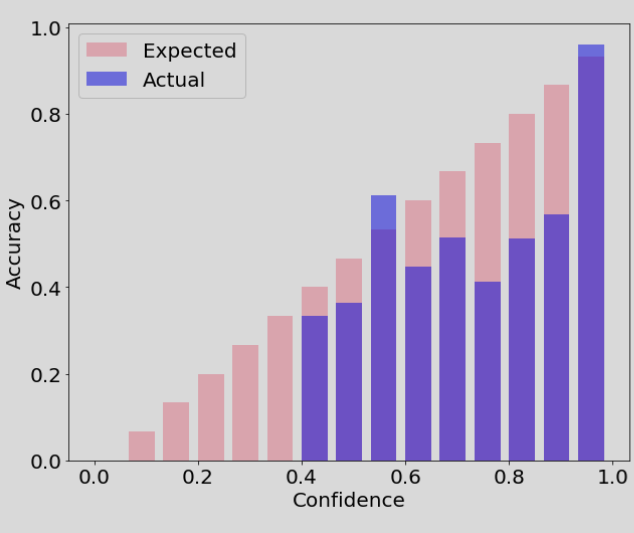

## Baseline experiment

In [ ]:
with torch.no_grad():
    for data in valid_loader:
        inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
        outputs, __, __ = model(inputs.transpose(1,2))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
val_acc = 100. * correct / total
val_metrics = {"val_accuracy":val_acc}
wandb.log(val_metrics)

NameError: name 'valid_loader' is not defined

In [ ]:
# start a new wandb run to track this script
wandb.init(
    project="PCloud",
    name="Different parameter scale",
    group="Non-overlaping params",
    job_type="eval",
    # track hyperparameters
    config={
        "learning_rate": 0.001,
        "architecture": "Tnet",
        "dataset": "BaselNETine",
        "N": 100, #Points in a cloud
        "n": 100,
        "epochs": 100,
        "train_batch_size": 64,
        "valid_batch_size": 64,
        "train_param_range": [1,4],
        "test_param_range": [5,6], #100, 150 другой масштаб; [0,1] - normalize;
        "noise": 0.07
    }
)

# Copy config
config = wandb.config

# Generate data
generate_save(N=3, n=config['n'], gen_func=gen_callback_ab(generate_sphere_coords,*config['train_param_range']), class_name='spheres', force_generation=True, split='train')
generate_save(N=config['N'], n=config['n'], gen_func=gen_callback_ab(generate_sphere_coords,*config['test_param_range']), class_name='spheres', force_generation=True, split='test')
generate_save(N=3, n=config['n'], gen_func=gen_callback_ab(generate_torus_coords,*config['train_param_range']), class_name='tori', force_generation=True, split='train')
generate_save(N=config['N'], n=config['n'], gen_func=gen_callback_ab(generate_torus_coords,*config['test_param_range']), class_name='tori', force_generation=True, split='test')

# Create datasets
train_ds = PointCloudData(folder='train' )
valid_ds = PointCloudData(folder='test', noise=config["noise"])

# Create loaders
train_loader = DataLoader(dataset=train_ds, batch_size=config['train_batch_size'], shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=config['valid_batch_size'], shuffle=True)

# Define model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = PointNet().to(device)

# Define loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
loss_func = pointnetloss

# Training

for epoch in range(config['epochs']):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
        optimizer.zero_grad()
        outputs, m3x3, m64x64 = model(inputs.transpose(1,2))

        loss = loss_func(outputs, labels, m3x3, m64x64)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        metrics = {"train/train_loss": running_loss,
                   "train/epoch": epoch,
                   "train/batch": i}
        wandb.log(metrics)


    model.eval()
    correct = total = 0

    # validation
    if valid_loader:
        with torch.no_grad():
            for data in valid_loader:
                inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                outputs, __, __ = model(inputs.transpose(1,2))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = 100. * correct / total
        val_metrics = {"val_accuracy":val_acc}
        wandb.log(val_metrics)

    if train_loader:
        with torch.no_grad():
            for data in train_loader:
                inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                outputs, __, __ = model(inputs.transpose(1,2))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        train_acc = 100. * correct / total
        train_metrics = {"train_accuracy":train_acc}
        wandb.log(train_metrics)

# Save model
#torch.save(model.state_dict(), "model.pth")
#wandb.log_model("./model.pth", "point_cloud_model")

wandb.finish()

train/batch,▃▆▆██▆▁▁█▆▆▁█▆▃▆██▁▃▃▃███▃▁▁▆▁▁▁▆█▁▃▆▃▆▃
train/epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
train/train_loss,▃▆█▁▆▆█▆█▆▇▃▁▁▃▅▃█▆▆▃▃▁▁▅█▅▅█▁▃▃▃▁▇▁▁█▃▅
train_accuracy,▅▅▅▃▅▄▂▅▅▂▇▅▄▄▄▄▄▄█▄▂▄▆██▄▅▂▄▇▅▂▂▁▄▁▂▇▆▇
val_accuracy,▅▅▅▅▅▁▂▃▆▆▅▃█▅▄▄▆▃▂▂█▂▇▇▃▄▅▅▂▅▄▄▄▂▃▆▇▆▆▅
train/batch,3
train/epoch,99
train/train_loss,2.79535
train_accuracy,50.5
val_accuracy,51


#Cycled experiments

In [ ]:
# start a new wandb run to track this script
for n in range(10,150,20):
    wandb.init(
        settings=wandb.Settings(start_method="fork"),
        project="PCloud",
        name=f"Cycle n={n}_2",
        group="Cyclic-n",
        job_type="eval",
        # track hyperparameters
        config={
            "learning_rate": 0.0001,
            "architecture": "Tnet",
            "dataset": "Baseline",
            "N": 60, # Points in a cloud
            "n": n,
            "epochs": 30,
            "train_batch_size": 64,
            "valid_batch_size": 64,
            "train_param_range": [1,4],
            "test_param_range": [5,10],
        }
    )

    # Copy config
    config = wandb.config

    # Generate data
    generate_save(N=config['N'], n=config['n'], gen_func=gen_callback_ab(generate_sphere_coords,*config['train_param_range']), class_name='spheres', force_generation=True, split='train')
    generate_save(N=config['N'], n=config['n'], gen_func=gen_callback_ab(generate_sphere_coords,*config['test_param_range']), class_name='spheres', force_generation=True, split='test')
    generate_save(N=config['N'], n=config['n'], gen_func=gen_callback_ab(generate_torus_coords,*config['train_param_range']), class_name='tori', force_generation=True, split='train')
    generate_save(N=config['N'], n=config['n'], gen_func=gen_callback_ab(generate_torus_coords,*config['test_param_range']), class_name='tori', force_generation=True, split='test')

    # Create datasets
    train_ds = PointCloudData(folder='train')
    valid_ds = PointCloudData(folder='test')

    # Create loaders
    train_loader = DataLoader(dataset=train_ds, batch_size=config['train_batch_size'], shuffle=True)
    valid_loader = DataLoader(dataset=valid_ds, batch_size=config['valid_batch_size'], shuffle=True)

    # Define model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = PointNet().to(device)

    # Define loss and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    loss_func = pointnetloss

    # Training

    for epoch in range(config['epochs']):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = model(inputs.transpose(1,2))

            loss = loss_func(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            metrics = {"train/train_loss": running_loss,
                      "train/epoch": epoch,
                      "train/batch": i}
            wandb.log(metrics)


        model.eval()
        correct = total = 0

        # validation
        if valid_loader:
            with torch.no_grad():
                for data in valid_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = model(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            val_metrics = {"val_accuracy":val_acc}
            wandb.log(val_metrics)

    # Save model
    torch.save(model.state_dict(), "model.pth")
    wandb.log_model("./model.pth", "point_cloud_model")

    wandb.finish()

train/batch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/train_loss,██▆▆▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂██▇▅▅▇▅
train/batch,0
train/epoch,29
train/train_loss,0.03934
val_accuracy,60


train/batch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/train_loss,█▆▅▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/batch,0
train/epoch,29
train/train_loss,0.02499
val_accuracy,50


train/batch,▁█▁█▁▁█▁███▁▁█▁▁▁█▁█▁██▁█▁██▁██▁█▁██▁▁██
train/epoch,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train/train_loss,▅█▄▇▄▃▆▃▅▂▃▂▂▂▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▅▇▆▅▇▇▇█████████
train/batch,1
train/epoch,29
train/train_loss,0.03797
val_accuracy,95


train/batch,▅▅▁▅█▅█▁▅██▅█▁▅▁▅▅▁█▁▅▁▅███▁▅▁▅█▅█▅█▁▅██
train/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
train/train_loss,▅█▆█▃▂▂▂▂▃▂▂▇▁▂▁▂▁▁▂▁▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▃
val_accuracy,▂▂▂▂▂▂▂▂▁▂▂▂▄▅▆▇▇▇▇▇▇▇▇▇▆▄▄▅██
train/batch,2
train/epoch,29
train/train_loss,0.10533
val_accuracy,96.42857


train/batch,█▁▅▁▅▅█▁█▁█▁▅█▁▅█▁█▁▁▅█▁▅▁▅▁█▅▅█▁▅▁▅▅█▁█
train/epoch,▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
train/train_loss,█▅▇▄▂▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▅▇▇████████████
train/batch,2
train/epoch,29
train/train_loss,0.03418
val_accuracy,97.77778


train/batch,▁▃█▁▆█▁▆██▆█▁▆███▃█▁▃▆█▁▁▆▁▃▆▃▆▁▃▁█▃▆▁▃█
train/epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/train_loss,▅▆█▃▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_accuracy,▁▁▁▁▁▁▁▁▁▄▇▇▇▇▇███████████████
train/batch,3
train/epoch,29
train/train_loss,0.276
val_accuracy,99.54545


train/batch,▃▁▆█▅▃▆██▃▅▅▁▃█▅▁▆▁▆█▆▃▆█▆▃▆▃▅█▃█▃▅██▁▅█
train/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇██
train/train_loss,█▃▄▂▃▂▂▃▂▂▁▁▂▁▁▃▁▁▁▁▂▅▁▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▄
val_accuracy,▁▁▁▁▁▁▁▁▁▃▅▅▄▄▆▆▆▄▅▇█████▇████
train/batch,4
train/epoch,29
train/train_loss,1.56691
val_accuracy,96.15385


## Test

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
pointnet = PointNet()
pointnet.load_state_dict(torch.load('model.pth'))
pointnet.eval();

<ipython-input-94-774d9a176428>:2: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [ ]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))

        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())



Batch [   1 /    4]
Batch [   2 /    4]
Batch [   3 /    4]
Batch [   4 /    4]


In [ ]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[82, 18],
       [ 8, 92]])

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


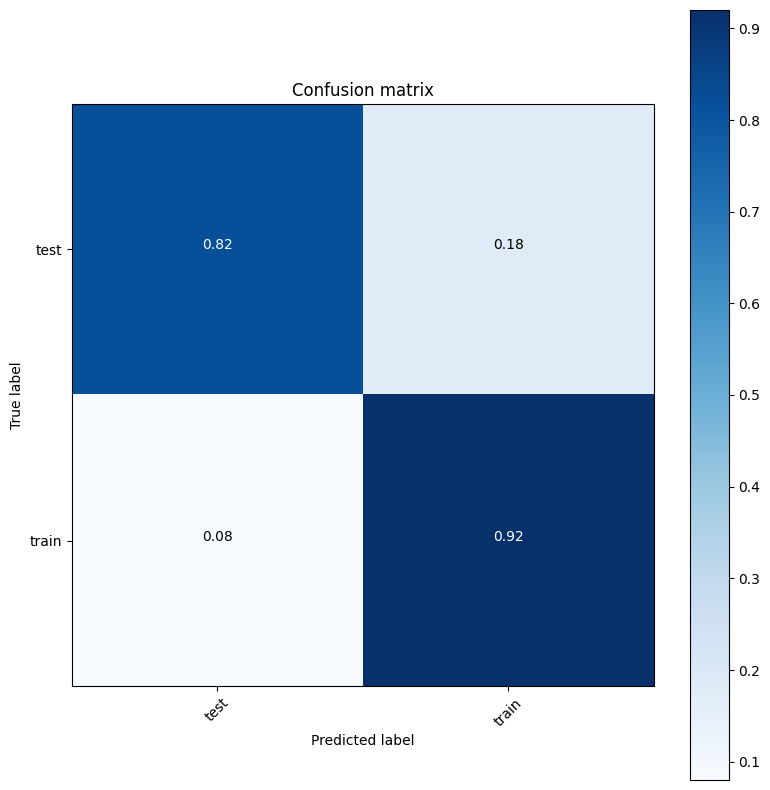

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

Confusion matrix, without normalization


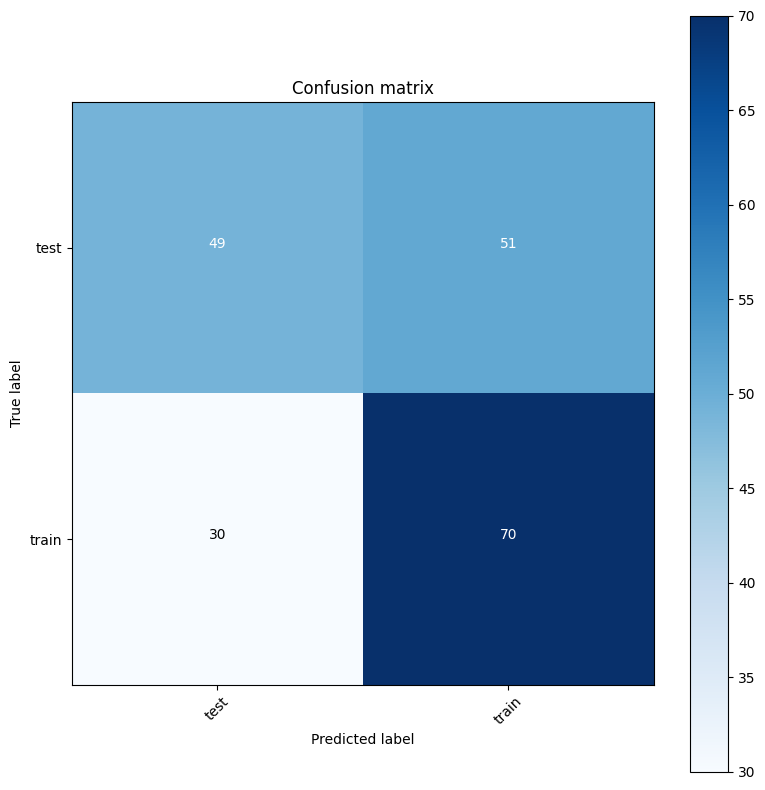

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)

# Parameters deduction

# TDA approach


In [ ]:
!python -m pip install -U giotto-tda

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.6/554.6 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 19.8 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [ ]:
pointcloud = np.loadtxt('./dataset/train/torus/5')

In [ ]:
pointcloud.shape
pointcloud.reshape(1,300,3).shape


(1, 300, 3)

In [ ]:
  import plotly.express as px
  fig = px.scatter_3d(x= pointcloud[:,0] ,y=pointcloud[:,1],z=pointcloud[:,2])
  fig.show()

In [ ]:
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy


VR = VietorisRipsPersistence(homology_dimensions=[0, 1, 2])  # Parameter explained in the text-
diagrams = VR.fit_transform(pointcloud.reshape(1,300,3))
print(diagrams.shape)
PE = PersistenceEntropy()
features = PE.fit_transform(diagrams)
print(features)

(1, 433, 3)
[[8.08220624 5.63411531 5.19190801]]


In [ ]:
from gtda.plotting import plot_diagram

plot_diagram(diagrams[0])